
# Step 3 — Dimensionality Reduction with PCA (→ 3D for Quantum)

Reduce the 16-D features from Step 2 to **3 principal components** for the quantum pipeline.

- Load **scaled features** (or scale if only raw features exist)
- **Group split by actor** to avoid speaker leakage (default)
- **Fit PCA on TRAIN ONLY**, then transform train/test
- Save: `pca_model.pkl`, `pca_explained_variance.csv`, `pca3_train.csv`, `pca3_test.csv`


## Install (run if needed)

In [1]:

# %pip install numpy pandas scikit-learn matplotlib joblib


## Config

In [2]:

from pathlib import Path

# Place this notebook in thesis_code/notebooks/
BASE_DATA = Path("/Users/nishchalpokhrel/Documents/project/thesis_code/data")  # sibling of notebooks/
# If you run from elsewhere, set absolute path:
# BASE_DATA = Path("/Users/nishchalpokhrel/Documents/project/thesis_code/data")

PROCESSED_DIR = BASE_DATA / "processed"

# Inputs from Step 2
FEATURES_SCALED_CSV = PROCESSED_DIR / "features_16d_scaled.csv"
FEATURES_RAW_CSV    = PROCESSED_DIR / "features_16d.csv"
SCALER_IN_PATH      = PROCESSED_DIR / "scaler_standard.pkl"  # optional

# Outputs
PCA_MODEL_PATH = PROCESSED_DIR / "pca_model.pkl"
PCA_INFO_CSV   = PROCESSED_DIR / "pca_explained_variance.csv"
#PCA_TRAIN_CSV  = PROCESSED_DIR / "pca3_train.csv"
#PCA_TEST_CSV   = PROCESSED_DIR / "pca3_test.csv"

# Settings
N_COMPONENTS    = 6          # keep 3 PCs for quantum pipeline
VARIANCE_TARGET = None       # e.g., 0.90 to auto-choose k; leave None to force N_COMPONENTS
TEST_SIZE       = 0.2
RANDOM_STATE    = 42
USE_GROUP_SPLIT = True       # split by actor to avoid speaker leakage

print("BASE_DATA =", BASE_DATA.resolve())
print("Looking for:", FEATURES_SCALED_CSV.resolve())


BASE_DATA = /Users/nishchalpokhrel/Documents/project/thesis_code/data
Looking for: /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/features_16d_scaled.csv


## Imports & helpers

In [3]:

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
import matplotlib.pyplot as plt

FEAT_COLS = [f"mfcc_{i}" for i in range(13)] + ["pitch_mean", "rms_mean", "centroid_mean"]

def load_or_scale_features():
    """Load scaled features if available; else scale raw features here."""
    if FEATURES_SCALED_CSV.exists():
        df = pd.read_csv(FEATURES_SCALED_CSV)
        src = "scaled"
        scaler = joblib.load(SCALER_IN_PATH) if SCALER_IN_PATH.exists() else None
        return df, src, scaler
    if FEATURES_RAW_CSV.exists():
        df = pd.read_csv(FEATURES_RAW_CSV)
        df = df.dropna(subset=FEAT_COLS).copy()
        scaler = StandardScaler()
        df[FEAT_COLS] = scaler.fit_transform(df[FEAT_COLS])
        src = "scaled_from_raw"
        return df, src, scaler
    raise FileNotFoundError("Missing features_16d_scaled.csv and features_16d.csv in processed/. Run Step 2 first.")

def make_splits(df, test_size=0.2, random_state=42, use_group_split=True):
    """Group split by actor (if available) to avoid speaker leakage; else stratified by emotion."""
    y = df["emotion"].astype(str)
    has_actor = ("actor" in df.columns) and df["actor"].notna().any()
    if use_group_split and has_actor:
        groups = df["actor"].astype(str)
        splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(splitter.split(df[FEAT_COLS], y, groups=groups))
    else:
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(splitter.split(df[FEAT_COLS], y))
    return df.iloc[train_idx].reset_index(drop=True), df.iloc[test_idx].reset_index(drop=True)

def fit_pca_on_train(X_train, n_components=3, variance_target=None, random_state=42):
    """Fit PCA on training set; optionally auto-select k by variance target."""
    pca_full = PCA(random_state=random_state).fit(X_train)
    evr = pca_full.explained_variance_ratio_
    if variance_target is not None:
        k = int(np.searchsorted(np.cumsum(evr), variance_target) + 1)
        k = max(1, min(k, X_train.shape[1]))
    else:
        k = n_components
    pca = PCA(n_components=k, random_state=random_state).fit(X_train)
    return pca, {"evr": evr, "cum_evr": np.cumsum(evr), "chosen_k": k}


## Load features (prefer scaled)

In [4]:

df, used_src, loaded_scaler = load_or_scale_features()
print("Loaded:", used_src, "| rows:", len(df))
print(df[['emotion','actor'] + FEAT_COLS[:5]].head(3))


Loaded: scaled | rows: 864
  emotion     actor    mfcc_0    mfcc_1    mfcc_2    mfcc_3    mfcc_4
0   angry  Actor_01 -0.259571 -0.302047  0.919673  0.557987  0.425216
1   angry  Actor_01  1.144918 -0.452239  1.018404  0.214387  0.260662
2   angry  Actor_01  0.797066 -0.043544  1.244765  0.927850  0.563087


## Train/Test split

In [5]:

train_df, test_df = make_splits(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, use_group_split=USE_GROUP_SPLIT)
print("Train size:", len(train_df), "| Test size:", len(test_df))
print("Train emotions:\n", train_df['emotion'].value_counts())
print("Test emotions:\n", test_df['emotion'].value_counts())


Train size: 684 | Test size: 180
Train emotions:
 emotion
angry      152
fearful    152
happy      152
sad        152
neutral     76
Name: count, dtype: int64
Test emotions:
 emotion
angry      40
fearful    40
happy      40
sad        40
neutral    20
Name: count, dtype: int64


## Fit PCA on TRAIN only

In [6]:

X_train = train_df[FEAT_COLS].values
pca_model, pca_info = fit_pca_on_train(
    X_train, n_components=N_COMPONENTS, variance_target=VARIANCE_TARGET, random_state=RANDOM_STATE
)
print("Chosen components:", pca_info['chosen_k'])
print("EVR (first 10):", np.round(pca_info['evr'][:10], 4))
print("CumEVR (first 10):", np.round(pca_info['cum_evr'][:10], 4))

# Save PCA artifacts
joblib.dump(pca_model, PCA_MODEL_PATH)
pd.DataFrame({
    "component": np.arange(1, len(pca_info['evr'])+1),
    "explained_variance_ratio": pca_info['evr'],
    "cumulative_explained_variance": pca_info['cum_evr']
}).to_csv(PCA_INFO_CSV, index=False)
print("Saved PCA model →", PCA_MODEL_PATH.resolve())
print("Saved variance info →", PCA_INFO_CSV.resolve())

# Name outputs dynamically based on the number of PCs actually kept
K = pca_model.n_components_
PCA_TRAIN_CSV = PROCESSED_DIR / f"pca{K}_train.csv"
PCA_TEST_CSV  = PROCESSED_DIR / f"pca{K}_test.csv"
print("Will save splits as:")
print("  ", PCA_TRAIN_CSV.resolve())
print("  ", PCA_TEST_CSV.resolve())



Chosen components: 6
EVR (first 10): [0.3698 0.1524 0.0983 0.089  0.0721 0.0534 0.0332 0.0312 0.0263 0.022 ]
CumEVR (first 10): [0.3698 0.5223 0.6206 0.7095 0.7816 0.8351 0.8683 0.8995 0.9258 0.9478]
Saved PCA model → /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/pca_model.pkl
Saved variance info → /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/pca_explained_variance.csv
Will save splits as:
   /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/pca6_train.csv
   /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/pca6_test.csv


## Transform train/test and save

In [7]:

pc_cols = [f"PC{i+1}" for i in range(pca_model.n_components_)]

X_train_pca = pca_model.transform(train_df[FEAT_COLS].values)
train_out = train_df[['path','emotion','actor']].copy() if 'path' in train_df.columns else train_df[['emotion','actor']].copy()
for i, c in enumerate(pc_cols): train_out[c] = X_train_pca[:, i]
train_out.to_csv(PCA_TRAIN_CSV, index=False)

X_test_pca = pca_model.transform(test_df[FEAT_COLS].values)
test_out = test_df[['path','emotion','actor']].copy() if 'path' in test_df.columns else test_df[['emotion','actor']].copy()
for i, c in enumerate(pc_cols): test_out[c] = X_test_pca[:, i]
test_out.to_csv(PCA_TEST_CSV, index=False)

print("Saved:", PCA_TRAIN_CSV.resolve())
print("Saved:", PCA_TEST_CSV.resolve())

train_out.head(3), test_out.head(3)


Saved: /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/pca6_train.csv
Saved: /Users/nishchalpokhrel/Documents/project/thesis_code/data/processed/pca6_test.csv


(                                                path emotion     actor  \
 0  /Users/nishchalpokhrel/Documents/project/thesi...   angry  Actor_02   
 1  /Users/nishchalpokhrel/Documents/project/thesi...   angry  Actor_02   
 2  /Users/nishchalpokhrel/Documents/project/thesi...   angry  Actor_02   
 
         PC1       PC2       PC3       PC4       PC5       PC6  
 0  0.421347  0.243389 -1.194296  0.611393 -0.320048  0.064521  
 1  0.747378  0.373317 -1.120472  0.990099 -0.409738 -0.413360  
 2  1.006623 -0.347377 -0.796462  0.930092 -0.497158 -0.185426  ,
                                                 path emotion     actor  \
 0  /Users/nishchalpokhrel/Documents/project/thesi...   angry  Actor_01   
 1  /Users/nishchalpokhrel/Documents/project/thesi...   angry  Actor_01   
 2  /Users/nishchalpokhrel/Documents/project/thesi...   angry  Actor_01   
 
         PC1       PC2       PC3       PC4       PC5       PC6  
 0 -2.126623  1.225995 -0.757403  0.472466  1.512426 -0.334877  
 1 -1

## (Optional) Explained variance plots

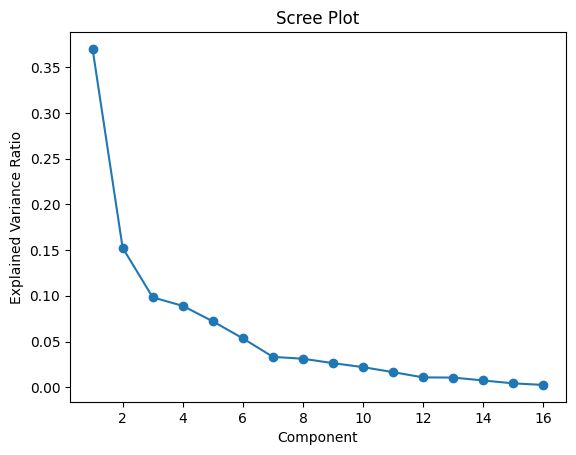

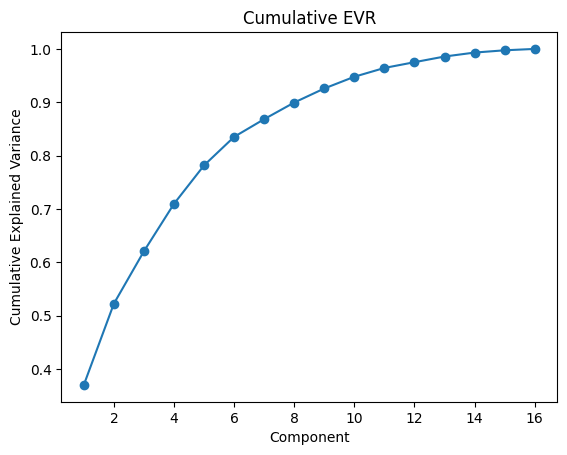

In [8]:

evr, cum = pca_info['evr'], pca_info['cum_evr']

plt.figure()
plt.plot(np.arange(1, len(evr)+1), evr, marker='o')
plt.xlabel("Component"); plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot"); plt.show()

plt.figure()
plt.plot(np.arange(1, len(cum)+1), cum, marker='o')
plt.xlabel("Component"); plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative EVR"); plt.show()
